# Proteína ERK2
### Obtención de los ligandos ubicados en la cavidad de la proteína
Esta libreta tinene como objetivo obtener los **ligandos cocristalizados en ele sitio activo de la proteína ERK2**, difereciando dichas moléculas de iones o moléculas del solvente, así como de ligandos o inhibidores alostéricos.

In [1]:
from prody import *
import numpy as np
import csv
import pandas as pd

In [2]:
# Nombre de la proteina de interés
prot_name = 'erk2'

**Carga del dataframe con la información de la proteína**

In [3]:
# abrir la tabla de metadatos de las proteinas
import glob, os
# Directorio hacia el archivo csv
path_df_csv = glob.glob(os.path.join('.', 'data', 
                                     F'TABLA_MTDATA_{prot_name.upper()}_*_crys.csv'))

df_prot = pd.read_csv(path_df_csv[0], index_col = 0,
                     converters={"NameLigs": lambda x: x.strip("[]").replace("'", "").split(", ")}, 
                      # Convierte en lista la celda del nombre de los ligandos
                      # A falta de una solución más prolija
                      # TODO: Trabajar con archivos json
                     )
df_prot.set_index('PDB_ID', inplace=True)
df_prot.tail(3)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs
PDB_ID,,,,,,,,,,,,
6qal,erk2 mini-fragment binding,2019-03-27,1,A,1.57,359.0,93.055556,5.0,"[10, 3, 1, 8, 3]","[[1, 10], [34, 36], [161, 161], [331, 338], [3...",3.0,"[CME, HV2, SO4]"
6qaq,erk2 mini-fragment binding,2019-03-27,1,A,1.58,359.0,95.277778,4.0,"[10, 1, 3, 3]","[[1, 10], [161, 161], [331, 333], [358, 360]]",3.0,"[CME, HVQ, SO4]"
6qaw,erk2 mini-fragment binding,2019-03-27,1,A,1.84,358.0,93.333333,5.0,"[10, 1, 1, 9, 3]","[[1, 10], [127, 127], [161, 161], [330, 338], ...",3.0,"[CME, HVE, SO4]"


In [4]:
df_prot.shape

(166, 12)

### Conteo de estructuras con ligandos
Preguntamos cuántas y cuales estructuras cristalográficas tienen ligandos y creamos una nueva tabla con ellas (`df_prot_ligs`).  

In [5]:
df_prot_ligs = df_prot[df_prot.NumLigs > 0]
print(F'{len(df_prot_ligs)} de {len(df_prot)} cristales con al menos un ligando.')

156 de 166 cristales con al menos un ligando.


#### Nota:
> **No todas estas moléculas son ligandos de la proteína**, ya que sólo hemos identificado cadenas en el archivo pdb con la designación **HETATM**; pudiendo ser iones, residuos no éstandar (con modificaciones postraduccionales) o moléculas del cosolvente usado durante obtención de la estructura.  
Por lo tanto, si es ligando o no lo determinamos más adelante.

### ¿Cuántos ligandos diferentes hay?
Ahora preguntamos cuántas moléculas distintas han sido co-cristalizadas con la proteína.

In [6]:
# ¿Cuantos ligandos hay en total?
import itertools
# Lista de nombre de todos los ligandos
lig_full_list = list( itertools.chain.from_iterable( df_prot.NameLigs ) )
print(F'En total hay {len(lig_full_list)} moléculas HETATM,')


lig_all_list = list(set(lig_full_list))
print(F'de las cuales {len(lig_all_list)} son moléculas DISTINTAS.')

En total hay 459 moléculas HETATM,
de las cuales 152 son moléculas DISTINTAS.


## Moléculas en la cavidad catalítica
Ahora procedemos a identificar qué moléculas se encuentran en el sitio activo de la proteína, y si éstas tienen un peso molecular suficcientemente grande como para ser diferenciadas de posibles moléculas del solvente.

### Estructura de referencia
Tomamos como referencia alguna estructura del DataFrame con ligandos:

In [7]:
df_prot_ligs.head(5)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs
PDB_ID,,,,,,,,,,,,
1gol,coordinates of rat map kinase erk2 with an arg...,1997-03-12,1,A,2.8,354.0,99.166667,1.0,[3],"[[1, 3]]",2.0,"[ATP, MG]"
1pme,structure of penta mutant human erk2 map kinas...,1999-06-08,1,A,2.0,354.0,92.500000,4.0,"[15, 3, 1, 8]","[[1, 15], [33, 35], [161, 161], [330, 337]]",3.0,"[CME, SB2, SO4]"
1tvo,the structure of erk2 in complex with a small ...,2005-09-13,1,A,2.5,360.0,97.222222,2.0,"[7, 3]","[[1, 7], [358, 360]]",1.0,[FRZ]
1wzy,crystal structure of human erk2 complexed with...,2005-12-20,1,A,2.5,360.0,97.222222,2.0,"[7, 3]","[[1, 7], [358, 360]]",1.0,[F29]
2erk,phosphorylated map kinase erk2,1998-07-01,1,A,2.4,353.0,98.055556,1.0,[7],"[[1, 7]]",2.0,"[PTR, TPO]"


Pra este caso la primer estructura es una buena opción, pues **no posee gaps en la región del pocket y tiene como ligando al ATP**, sustrato de la proteína.

In [8]:
print(F'Estructura de referencia:\n{df_prot_ligs.index[0]}')

Estructura de referencia:
1gol


### Lista de residuos del sitio activo
Consiste en los iguiente:
- Usar la estructura de referencia que incluya a la proteína y su ligando.
    - El pdb_id de la referencia y el nombre del ligando son declarados.
- Se establece un *cutoff* en Ángstroms.
- Se seleccionan todos los residuos de la proteína que tengan algún átomo a una distancia igual o menor al *cutoff* con respecto a los átomos del ligando.
- Se obtiene la lista de residuos que cumplen el criterio anterior.
- Visualizamos con *nglview*.

In [9]:
# Cargamos la estructura PDB usando prody
pdbid_ref_name = '1gol'
ligand_name = 'ATP'
cutoff = 8
structure = parsePDB(F'../ARCHIVOS/CRISTALES/PDB_{prot_name.upper()}_RAW_files/{pdbid_ref_name}.pdb.gz')
# Selecion de los residuos a 8 agstroms del ligando en la cavidad
selected_residues = structure.select(F'within {cutoff} of resname {ligand_name} and name CA')
# Obtenemos la secuencia de los residuos
residues_list = selected_residues.getResnums()
# Convertimos la lista de resiudos a un string
residues_list_str = " ".join(residues_list.astype(str))
residues_list_str

@> 3012 atoms and 1 coordinate set(s) were parsed in 0.04s.


'29 30 31 32 35 36 37 38 39 49 50 51 52 82 102 103 104 105 106 107 108 109 111 112 151 152 153 154 164 165'

### Visualización del sitio activo

In [10]:
# Seleccionamos todos los átomos de los residuos en selected_residues
pocket_atoms = structure.select(F'resnum {residues_list_str}')
# Obtenemos los índices de los átomos
pocket_atoms_index = pocket_atoms.getIndices()

Esta selección debe corroborarse de forma visual, asegurándonos que la molécula sea un inhibidor a sustrato en el sitio de interés de la proteína. Pra ello se puede usar UCSF Chimera, o, en este caso nglviewer:

In [16]:
import nglview as nv
view = nv.show_prody(structure)
view.clear_representations()
view.add_representation('cartoon', selection='protein', color='white')
view.add_ball_and_stick(selection = ligand_name, color='orange', linewidth=3.)
view.add_licorice(selection = pocket_atoms_index, color='red')
view.add_cartoon(selection = pocket_atoms_index, color='red')
view

NGLWidget()

In [19]:
view.render_image()

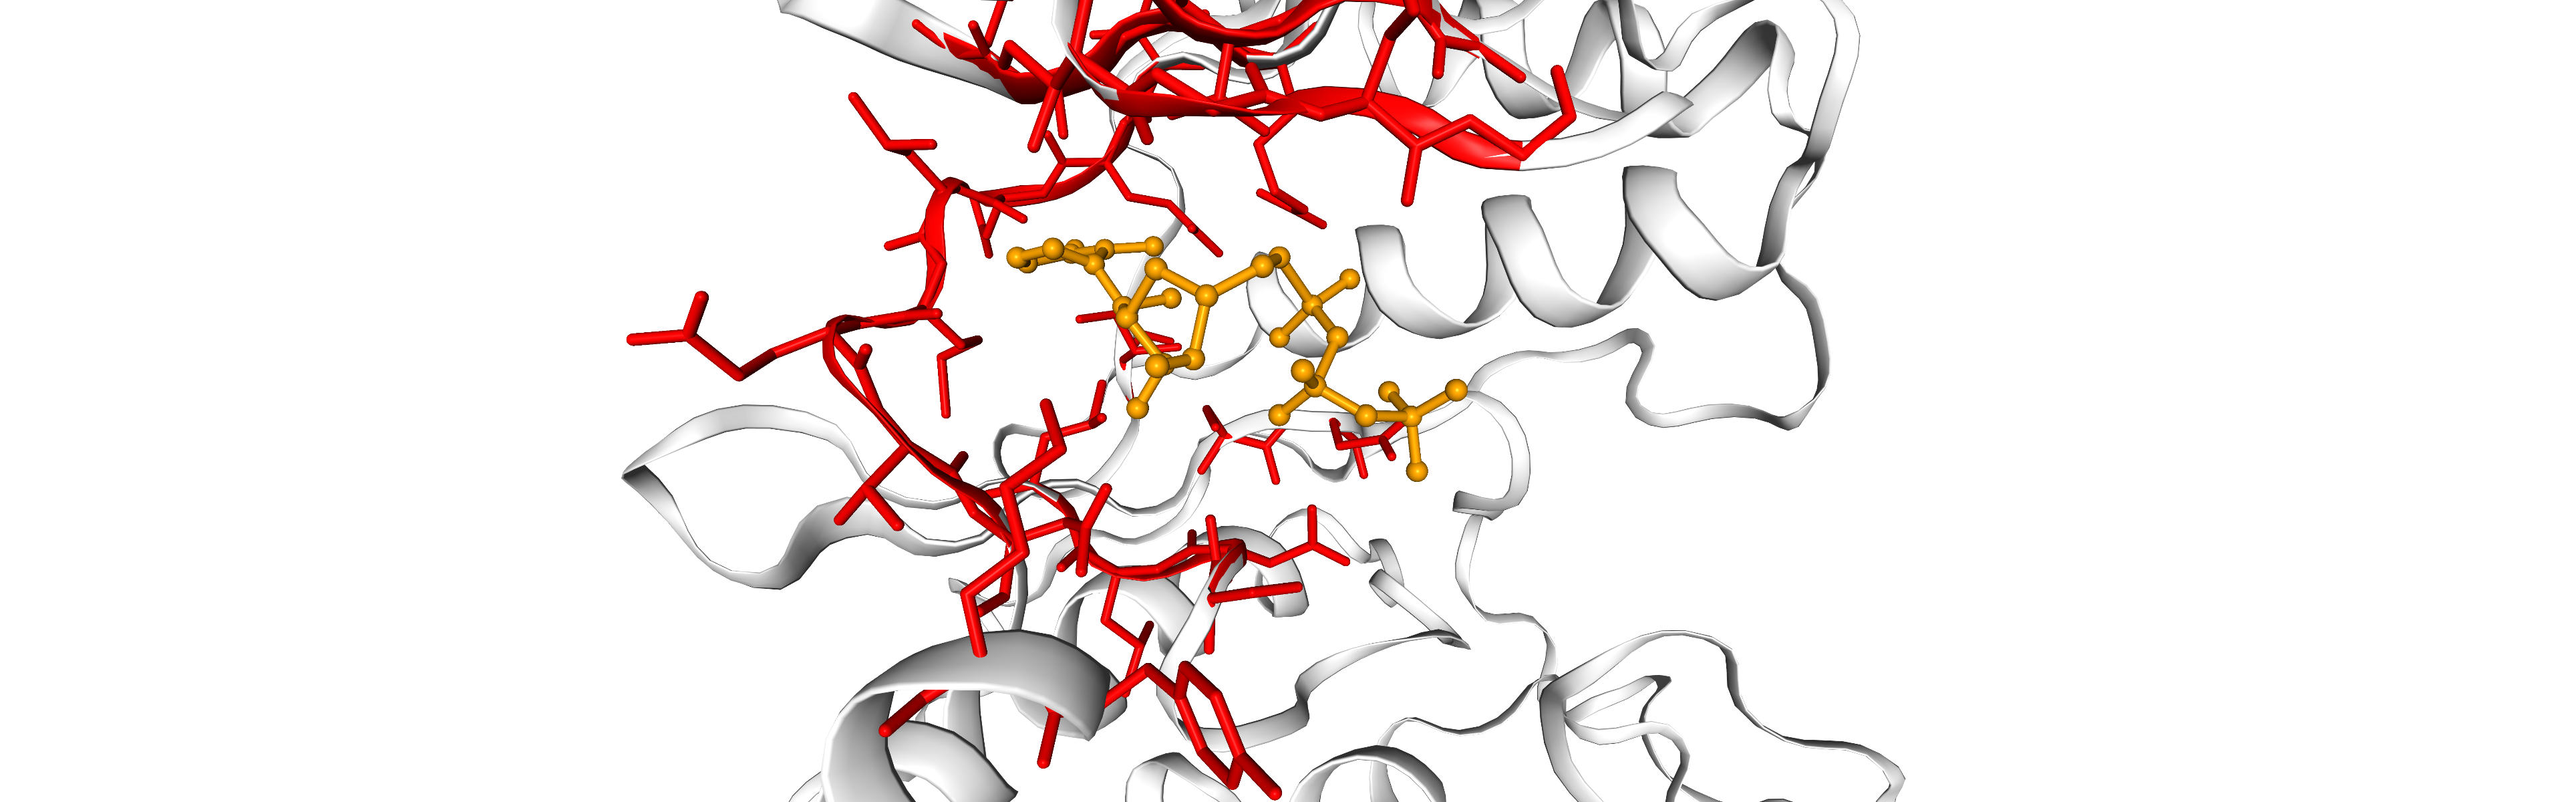

In [18]:
view._display_image()

## Determinación de los ligandos
Ahora, procedemos a utilizar la estructura de referencia modelada con *Modeller*. Hay que recordar que todas las estructuras modeladas fueron alineadas previamente tomando en cuenta la estructura secundaria de la proteína, y que el alineamiento incluyó la reposición relativa de los ligandos.

In [20]:
ref_strc_file = F'../ARCHIVOS/CRISTALES/PROT_{prot_name.upper()}_PREPARADAS/PREP_ALL_ENSAMBLE/{pdbid_ref_name}_ENS.pdb'
ref_structure = parsePDB(ref_strc_file)

@> 5830 atoms and 1 coordinate set(s) were parsed in 0.08s.


Ahora calculamos el centro de *pocket*, que en realidad es el centro geométrico definido por los carbonos alfa de la lista de residuos `residues_list`.

In [21]:
# Cálculo del centro total de la proteína de referencia
centro_strc_total = calcCenter(ref_structure).round(3)

# Definimos los átomos del pocket
pocket = ref_structure.select("resnum " + residues_list_str)
pocket_center = calcCenter(pocket)

# Solo para comparar:
print("Centro de la estructura completa:", centro_strc_total)
print("Centro considerando todos los átomos de los residuos del pocket:", pocket_center)

Centro de la estructura completa: [58.56  25.207  7.139]
Centro considerando todos los átomos de los residuos del pocket: [52.66540795 36.61452929 11.42405439]


### Visualizamos
Cualquier molécula que tenga un átomo en contacto con la esfera, será considerada como ligando unido al sitio activo.

In [22]:
view_2 = nv.show_prody(ref_structure)
view_2.shape.add_sphere( pocket_center.tolist(), [0, 0, 0], 3)
view_2.add_licorice(selection = pocket.getIndices(), color='magenta')
view_2

NGLWidget()

In [25]:
view_2.render_image()

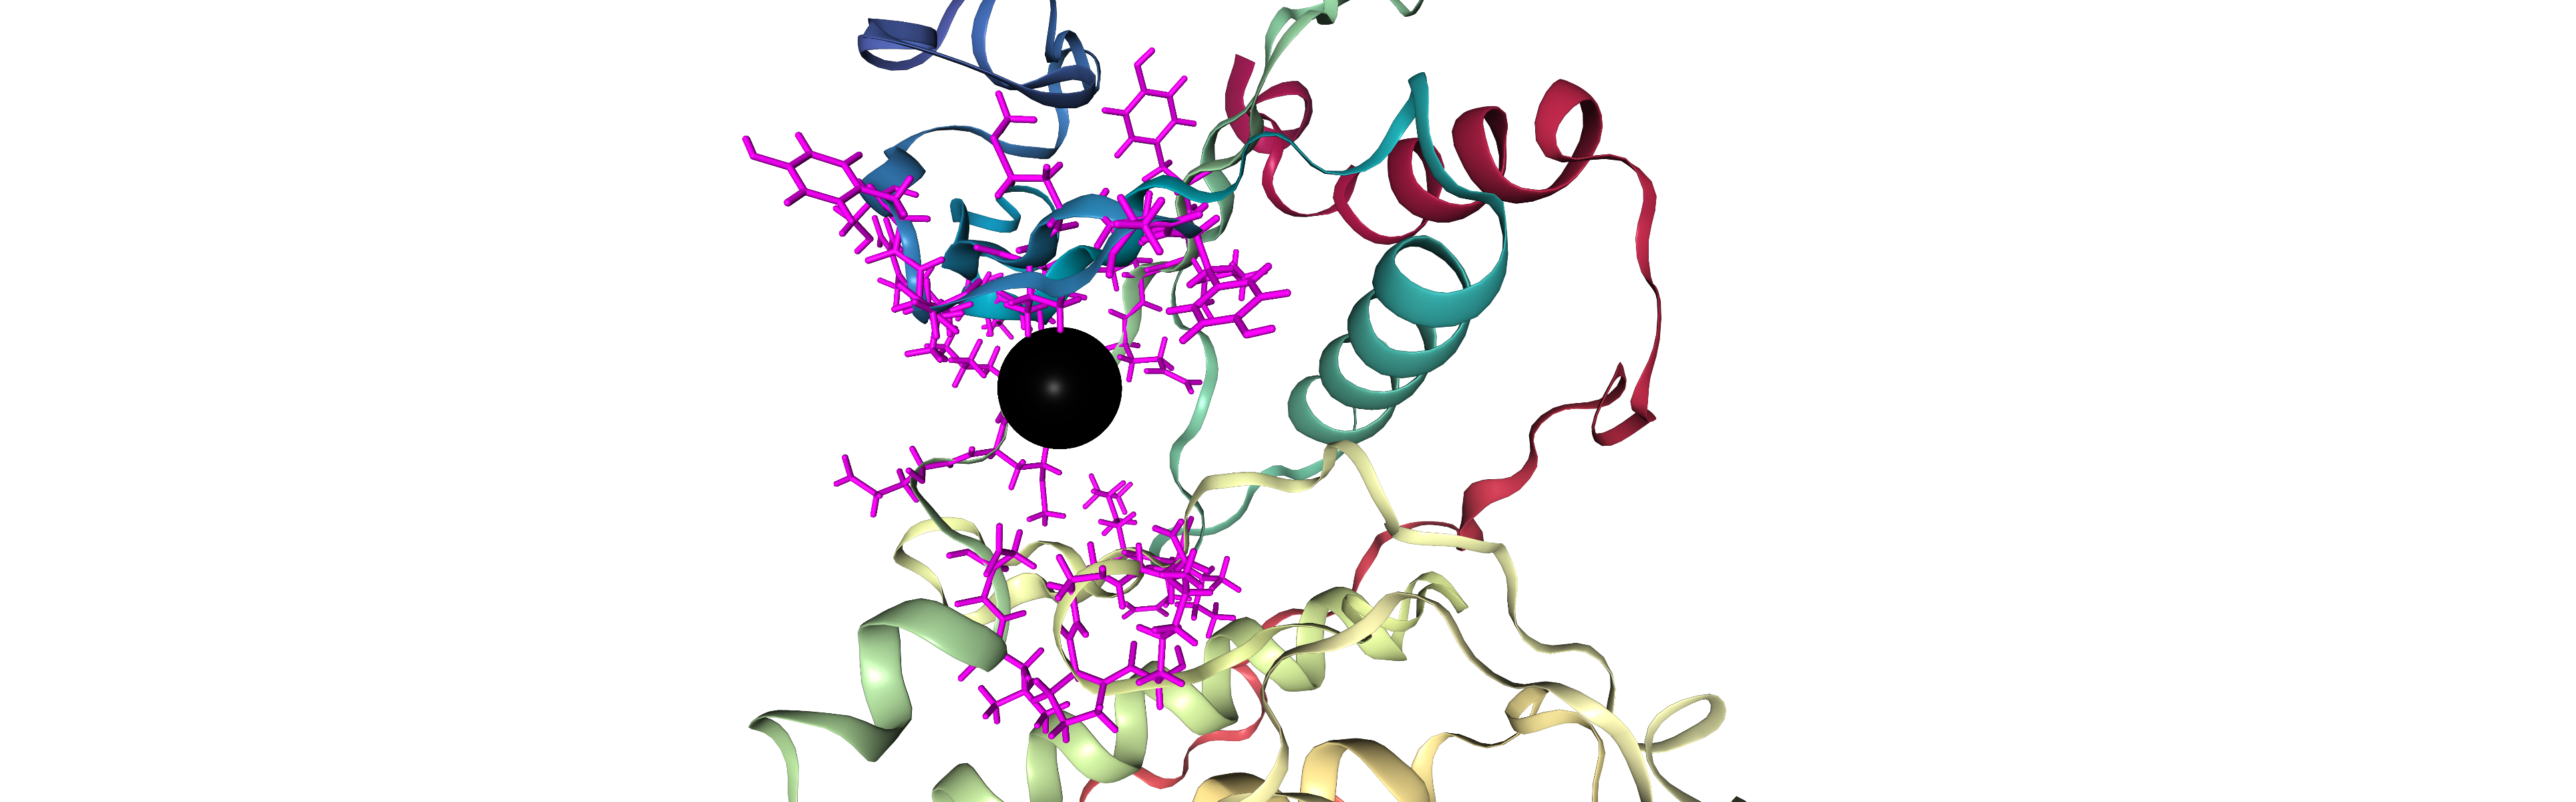

In [26]:
view_2._display_image()

### Pasos y función para obtener los ligandos

In [27]:
# Definimos los directorios de trabajo
RAW_LIG_DIR = F'../ARCHIVOS/CRISTALES/LIGS_{prot_name.upper()}/RAW/'
PROT_CHAINS_DIR = F'../ARCHIVOS/CRISTALES/PROT_{prot_name.upper()}_PREPARADAS/PREP_ALL_ENSAMBLE/'

# Directorio de salida (lo creamos si no existe):
PK_LIGS_DIR = F'../ARCHIVOS/CRISTALES/LIGS_{prot_name.upper()}/POCKET_LIGS/'
import os
if not os.path.exists(PK_LIGS_DIR):
    os.makedirs(PK_LIGS_DIR)

In [28]:
def get_pocket_ligand(pdb_id,
                       pocket_residues = residues_list_str,
                       cutoff = 2.0,
                       raw_lig_dir = RAW_LIG_DIR,
                       prot_chain_dir = PROT_CHAINS_DIR,
                       pk_ligs_dir = PK_LIGS_DIR,
                       write_files = True):
    # 1) Se carga cargan las moléculas HETATM usando Prody
    try:
        lig = parsePDB(raw_lig_dir + pdb_id  + "_lig.pdb")
    except Exception as e:
        print("La proteina", pdb_id, "NO TIENE LIGANDO.")
        return(None, None)
    # 2) Se carga la proteína y se seleccionan los residuos que definen el pocket
    protein = parsePDB( prot_chain_dir + pdb_id + "_ENS.pdb" )
    protein_pocket = protein.select("resid " + pocket_residues)
    
    # Se seleccionan los ligandos (RESIDUOS no protéicos) que estén a no más de cutoff A
    # de cualquier átomo de los residuos del pocket de la proteína
    lig_sel = lig.select('within ' + str(cutoff) + ' of inhibitor', inhibitor = protein_pocket)
    if lig_sel is None:
        print("La proteina", pdb_id, "no tiene ligando en el pocket.")
        return(None, None)
    
    # Se obtine la lista de moléculas que cumplen el criterio anterior
    inhibidor_list = np.unique( lig_sel.getResnums() )
    print( inhibidor_list )
    
    # Calcula el centro geométrico del pocket de la proteína
    prot_pocket_center = calcCenter(protein_pocket)
    
    # Puede que haya más de una molécula en el pocket 
    # (debido a presencia de iones, cosolvente o residuos modificados)
    # Se itera entre cada molecula del ligando, se calcula su masa y se mantiene el ligando con mayor masa 
    heavier_lig_mass = 0
    true_lig = ""

    for i in inhibidor_list:
            mol = lig.select("resnum " + str(i))
            mass = mol.getMasses().sum()
            # Se considera ligando sólo si su masa es igual o mayor a la de una molécula de benceno: 78,11
            if mass <= 78:
                continue
            # Si las masas de dos moléculas son iguales, decide entre la molécula más cerana
            if mass == heavier_lig_mass :
                dist_prot_m1 = calcDistance(prot_pocket_center, calcCenter(mol))
                dist_prot_m2 = calcDistance(prot_pocket_center, calcCenter(true_lig))
                if dist_prot_m1 < dist_prot_m2:
                    heavier_lig_mass, true_lig = mass, mol
                    continue
            # Si el ligando i es más pesado que i - 1, se actualizan los datos
            heavier_lig_mass, true_lig = (mass, mol) if mass > heavier_lig_mass else (heavier_lig_mass, true_lig)
            
    # Se guarda el ligando sólo si su masa es igual o mayor a la de una molécula de benceno: 78,11
    # si el ligando aparece 2 veces cerca del pocket, se elige la molécula más cercana al centro
    if true_lig != "": # Si el ligando existe y su masa fue mayor a 78,11, se procede
        # Se extrae el nombre del ligando
        name_lig = np.unique( true_lig.getResnames() )[0]

        # Se combinan proteína y ligando en un solo objeto AtomGroup, de tal manera que
        # sea posible superponer las estructuras de la proteína de acuerdo a los residuos de su pocket
        # y esto afcete la psoición del ligando
        complejo_PL = protein + true_lig.toAtomGroup()
        if write_files:
            # Se guardan ligando y proteína alineados según la estructura de referencia
            print(F'Proteína {pdb_id}: ligando {name_lig} guardado.')
            writePDB( pk_ligs_dir + "/" + pdb_id + "_" + name_lig + "_LIG.pdb", 
                      complejo_PL.select("resname " + name_lig) )
        return(name_lig, heavier_lig_mass)
    else: 
        print(F"La proteina {pdb_id} NO TIENE LIGANDO.")
        return(None, None)

### Obtenemos los ligandos y actualizamos el dataframe
Finalmente se obtienen los ligandos y a la tabla de datos se le agrega la información sobre el inhibidor y su masa

In [33]:
# Se agregan dos columnas al dataframe
df_prot["Inhib"] = ""
df_prot["Inhib_mass"] = np.nan

# Se obtienen los ligandos
for pdb_id in df_prot.index:
    inhibidor = get_pocket_ligand(pdb_id, write_files=True, cutoff=3.0)
    df_prot.at[str(pdb_id), 'Inhib'] = inhibidor[0]
    df_prot.at[pdb_id, 'Inhib_mass'] = inhibidor[1]

@> 32 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.07s.
@> 42 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.


La proteina 1erk NO TIENE LIGANDO.
[581 582]
Proteína 1gol: ligando ATP guardado.
[1001]
Proteína 1pme: ligando SB2 guardado.


@> 25 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.
@> 28 atoms and 1 coordinate set(s) were parsed in 0.00s.
@> 5830 atoms and 1 coordinate set(s) were parsed in 0.06s.


[1001]
Proteína 1tvo: ligando FRZ guardado.
[1001]
Proteína 1wzy: ligando F29 guardado.
La proteina 2erk NO TIENE LIGANDO.
La proteina 2fys NO TIENE LIGANDO.


### Dataframe actualizado

In [31]:
df_prot.head(20)

,Title,Date,Entities,ChainID,Resolution,Identity,Coverage,NumGaps,GapLen,GapPos,NumLigs,NameLigs,Inhib,Inhib_mass
PDB_ID,,,,,,,,,,,,,,
1erk,structure of signal-regulated kinase,1997-05-15,1,A,2.30,355.0,99.166667,1.0,[3],"[[1, 3]]",0.0,[],None,NaN
1gol,coordinates of rat map kinase erk2 with an arg...,1997-03-12,1,A,2.80,354.0,99.166667,1.0,[3],"[[1, 3]]",2.0,"[ATP, MG]",ATP,398.0
1pme,structure of penta mutant human erk2 map kinas...,1999-06-08,1,A,2.00,354.0,92.500000,4.0,"[15, 3, 1, 8]","[[1, 15], [33, 35], [161, 161], [330, 337]]",3.0,"[CME, SB2, SO4]",SB2,342.0
1tvo,the structure of erk2 in complex with a small ...,2005-09-13,1,A,2.50,360.0,97.222222,2.0,"[7, 3]","[[1, 7], [358, 360]]",1.0,[FRZ],FRZ,314.0
1wzy,crystal structure of human erk2 complexed with...,2005-12-20,1,A,2.50,360.0,97.222222,2.0,"[7, 3]","[[1, 7], [358, 360]]",1.0,[F29],F29,350.0
2erk,phosphorylated map kinase erk2,1998-07-01,1,A,2.40,353.0,98.055556,1.0,[7],"[[1, 7]]",2.0,"[PTR, TPO]",,NaN
2fys,crystal structure of erk2 complex with kim pep...,2006-04-11,2,B,2.50,355.0,93.888889,4.0,"[9, 8, 4, 1]","[[1, 9], [178, 185], [331, 334], [360, 360]]",0.0,[],,NaN
2gph,docking motif interactions in the map kinase erk2,2006-07-04,2,A,1.90,354.0,95.833333,2.0,"[11, 4]","[[1, 11], [357, 360]]",0.0,[],,NaN
2ojg,"crystal structure of erk2 in complex with n,n-...",2007-02-06,1,A,2.00,360.0,93.611111,3.0,"[18, 2, 3]","[[1, 18], [332, 333], [358, 360]]",2.0,"[19A, SO4]",,NaN
